<a href="https://colab.research.google.com/github/dtuleva/Recipe_Recommendation_System/blob/main/paper_2_code_SM3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow-datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [3]:
# coding=utf-8
# Copyright 2024 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""SM3 optimizer for training extremely large models."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# import numpy as np

# import tensorflow.compat.v1 as tf


class SM3Optimizer(tf.train.Optimizer):
  """SM3 variant SM3-II from https://arxiv.org/abs/1901.11150 ."""

  def __init__(self, learning_rate, momentum, name="SM3"):
    """Construct a new SM3 optimizer.

    Args:
      learning_rate: A `Tensor` or a floating point value.  The learning rate.
      momentum: A `Tensor` or a floating point value. Momentum is not applied to
        sparse updates.
      name: Optional name prefix for the operations created when applying
        gradients.
    """
    super(SM3Optimizer, self).__init__(False, name)
    self._learning_rate = learning_rate
    self._momentum = momentum

  def _create_slots(self, var_list):
    for v in var_list:
      with tf.colocate_with(v):
        if self._momentum > 0:
          self._zeros_slot(v, "momentum", self._name)
        shape = np.array(v.get_shape())
        var_rank = len(shape)
        # We special case vectors and scalars as we can run the diagonal adagrad
        # update for those parameters.
        if var_rank > 1:
          for i, d in enumerate(shape):
            d_tensor = tf.convert_to_tensor(d)
            diag_init = tf.zeros([d_tensor])
            _ = self._get_or_make_slot(v, diag_init, "accumulator_" + str(i),
                                       self._name)
        else:
          _ = self._zeros_slot(v, "accumulator", self._name)

  def _prepare(self):
    learning_rate = self._call_if_callable(self._learning_rate)
    self._learning_rate_tensor = tf.convert_to_tensor(
        learning_rate, name="learning_rate")
    momentum = self._call_if_callable(self._momentum)
    self._momentum_tensor = tf.convert_to_tensor(momentum, name="momentum")

  def _shape_for_broadcasting(self, shape, i):
    # Reshape the accumulator to make it ready for broadcasting.
    rank = len(shape)
    # Replaces a `shape` of [M, N, K] with 1 in all dimensions except for i.
    # For eg: i = 1 returns [1, N, 1].
    return [1] * i + [shape[i]] + [1] * (rank - i - 1)

  def _compute_past_accumulator(self, accumulators, shape):
    rank = len(shape)
    accumulators_for_broadcasting = [
        tf.reshape(accumulators[i], self._shape_for_broadcasting(shape, i))
        for i in range(rank)
    ]
    # Computes the accumulator before adding the current gradient.
    # A[i, j, k] = min(A1[i], A2[j], A3[j])
    result = accumulators_for_broadcasting[0]
    for i in range(1, rank):
      # Compute the minimum accumulator value which is a tighter bound to the
      # gradient sum squares.
      #
      # Note: Here we are broadcasting to compute the minimum.
      result = tf.minimum(result, accumulators_for_broadcasting[i])
    return result

  def _apply_dense(self, grad, var):
    # SM3 upper bounds the gradient square sums:
    #
    # To illustrate:
    #
    # For a Tensor `T` of shape [M, N, K].
    #
    # `G` be its gradient of shape [M, N, K]
    #
    # SM3 keeps around three accumulators A1, A2, A3 of size M, N, K
    # respectively.
    #
    # `A` be the accumulator of shape [M, N, K]. `A` is not materialized until
    #   its needed for every step, and is approximated by A1, A2, A3.
    #
    # At every gradient update step the accumulators satisify:
    #   A1_t[i] >= Sum_{s <= t} G_t[i, j, k]^2 for all j, k.
    #   A2_t[j] >= Sum_{s <= t} G_t[i, j, k]^2 for all i, k.
    #   A3_t[k] >= Sum_{s <= t} G_t[i, j, k]^2 for all i, j.
    #
    # The RHS is the gradient sum squares.
    #
    # For every step we materialize the tensor `A` based on accumulated tensors
    # A1, A2 and A3.
    #
    #  A = min(A1[i], A2[j], A3[j]) + G[i, j, k]^2
    #
    # SM3 preconditioned gradient is
    #
    #  preconditioned G = A^{-0.5} * G
    #
    # We then update the individual accumulator factors as:
    #
    #  A1[i] = max_{j, k} A[i, j, k]
    #  A2[j] = max_{i, k} A[i, j, k]
    #  A3[k] = max_{i, j} A[i, j, k]
    #
    shape = np.array(var.get_shape())
    var_rank = len(shape)
    if var_rank > 1:
      accumulator_list = [
          self.get_slot(var, "accumulator_" + str(i)) for i in range(var_rank)
      ]
      accumulator = self._compute_past_accumulator(accumulator_list, shape)
      accumulator += grad * grad
    else:
      accumulator_var = self.get_slot(var, "accumulator")
      accumulator = tf.assign_add(accumulator_var, grad * grad)

    accumulator_inv_sqrt = tf.rsqrt(accumulator + 1e-30)
    scaled_g = (1.0 - self._momentum_tensor) * (grad * accumulator_inv_sqrt)
    accumulator_update_ops = []

    with tf.control_dependencies([scaled_g]):
      if var_rank > 1:
        # Updates individual accumulator factors as:
        #  A1[i] = max_{j, k} A[i, j, k]
        #  A2[j] = max_{i, k} A[i, j, k]
        #  A3[k] = max_{i, j} A[i, j, k]
        for i, accumulator_i in enumerate(accumulator_list):
          axes = list(range(i)) + list(range(i + 1, var_rank))
          new_accumulator_i = tf.reduce_max(accumulator, axis=axes)
          accumulator_update_ops.append(
              tf.assign(accumulator_i, new_accumulator_i))

    with tf.control_dependencies(accumulator_update_ops):
      if self._momentum > 0:
        gbar = self.get_slot(var, "momentum")
        update = tf.assign_add(gbar,
                               gbar * (self._momentum_tensor - 1.0) + scaled_g)
      else:
        update = scaled_g
      return tf.assign_sub(var, self._learning_rate_tensor * update)

  # This path is typically unused on TPUs, as gradients are densified.
  def _apply_sparse_shared(self, grad_values, grad_indices, var):
    shape = np.array(var.get_shape())
    var_rank = len(shape)
    # For sparse case, we only update the accumulator representing the sparse
    # dimension. In this case SM3 is similar to isotropic adagrad but with
    # better bound (due to the max operator).
    #
    # We do not use the column accumulator because it will updated for
    # every gradient step and will significantly overestimate the gradient
    # square. While, the row accumulator can take advantage of the sparsity
    # in the gradients. Even if one implements the column accumulator - it
    # will result in a no-op because the row accumulators will have lower
    # values.
    #
    # Note that: We do not run this code paths for our experiments in our paper
    # as on TPU all the sparse gradients are densified.
    if var_rank > 1:
      accumulator_var = self.get_slot(var, "accumulator_" + str(0))
      accumulator = tf.gather(accumulator_var, grad_indices)
      shape_for_broadcasting = tf.concat([[tf.shape(accumulator)[0]], [1] *
                                          (var_rank - 1)], 0)
      accumulator = tf.reshape(accumulator, shape_for_broadcasting)
      accumulator += grad_values * grad_values
    else:
      accumulator_var = self.get_slot(var, "accumulator")
      accumulator = tf.scatter_add(accumulator_var, grad_indices,
                                   grad_values * grad_values)

    accumulator_inv_sqrt = tf.rsqrt(accumulator + 1e-30)
    scaled_g = (grad_values * accumulator_inv_sqrt)
    updates = []
    with tf.control_dependencies([scaled_g]):
      if var_rank > 1:
        axes = list(range(1, var_rank))
        new_accumulator = tf.reduce_max(accumulator, axis=axes)
        updates = [
            tf.scatter_update(accumulator_var, grad_indices, new_accumulator)
        ]
    with tf.control_dependencies(updates):
      return tf.scatter_sub(var, grad_indices,
                            self._learning_rate_tensor * scaled_g)

  def _resource_apply_dense(self, grad, var):
    return self._apply_dense(grad, var)

  def _resource_apply_sparse(self, grad_values, var, grad_indices):
    return self._apply_sparse_shared(grad_values, grad_indices, var)

  def _apply_sparse(self, grad, var):
    return self._apply_sparse_shared(grad.values, grad.indices, var)

Create a resnet50 model an train it a few epochs to see the optimizer works. In the paper it is used for AmoebaNet-D on ImageNet; there is no ready to use AmoebaNet-D as far as I know, using subset of Imagenet - Imagenette to try it.

In [4]:
imagenette, info = tfds.load("imagenette/160px-v2", with_info = True)

In [5]:
# info

Nothing useful in info, labels from https://github.com/fastai/imagenette

In [6]:
labels = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]
labels_dict = {i: label for i, label in enumerate(labels)}
labels_dict

{0: 'tench',
 1: 'English springer',
 2: 'cassette player',
 3: 'chain saw',
 4: 'church',
 5: 'French horn',
 6: 'garbage truck',
 7: 'gas pump',
 8: 'golf ball',
 9: 'parachute'}

In [7]:
imagenette_train = imagenette["train"]

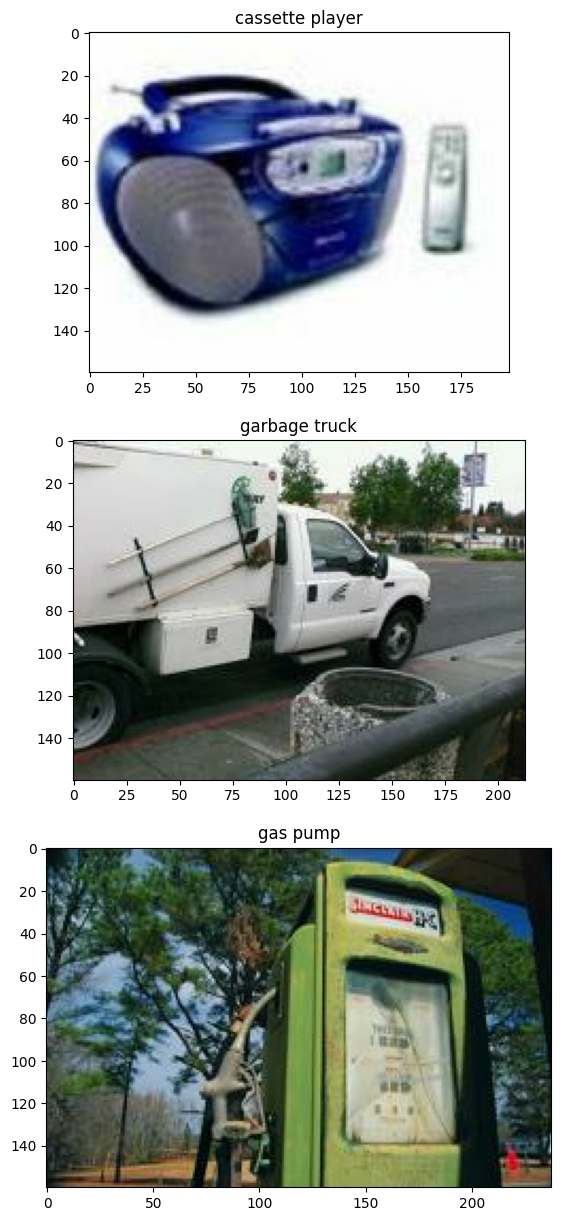

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 15))

for i, el in enumerate(imagenette_train.take(3)):
# for el in imagenette_train.take(1):
   axs[i].imshow(el["image"])
   axs[i].set_title(labels_dict[(el["label"].numpy())])

plt.show()


In [9]:
def resize_and_preprocess_image(element, image_size = (224, 224)): # need this size for resnets classification head

    img = element["image"]
    img = tf.image.resize(img, image_size)
    img = preprocess_input(img) # resnet50.preprocess_input

    return (img, element["label"])

    # return {"image": img, "label": element["label"]}

In [10]:
resnet = ResNet50(include_top = True, weights = None) # more classes in the head but who cares
resnet_2 = ResNet50(include_top = True, weights = None)

In [11]:
imagenette_train = imagenette_train.map(resize_and_preprocess_image)

In [12]:
resnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [13]:
resnet.fit(imagenette_train.batch(2).take(8), epochs = 8)

Epoch 1/8
8/8 [==============================] - 44s 2s/step - loss: 6.7871
Epoch 2/8
8/8 [==============================] - 13s 2s/step - loss: 3.9708
Epoch 3/8
8/8 [==============================] - 13s 2s/step - loss: 1.8853
Epoch 4/8
8/8 [==============================] - 13s 2s/step - loss: 0.7600
Epoch 5/8
8/8 [==============================] - 14s 2s/step - loss: 0.5259
Epoch 6/8
8/8 [==============================] - 13s 2s/step - loss: 0.4655
Epoch 7/8
8/8 [==============================] - 13s 2s/step - loss: 0.2960
Epoch 8/8
8/8 [==============================] - 13s 2s/step - loss: 0.2171


In [14]:
sm3_optimizer = SM3Optimizer(learning_rate = 0.1, momentum = 0.5)
sm3_optimizer

In [15]:
resnet_2.compile(optimizer = sm3_optimizer, loss="sparse_categorical_crossentropy")

In [16]:
resnet_2.fit(imagenette_train.batch(2).take(8), epochs = 8)

Epoch 1/8


Instructions for updating:
Colocations handled automatically by placer.


8/8 [==============================] - 35s 2s/step - loss: 55.3809
Epoch 2/8
8/8 [==============================] - 14s 2s/step - loss: 5.1630
Epoch 3/8
8/8 [==============================] - 13s 2s/step - loss: 2.8120
Epoch 4/8
8/8 [==============================] - 13s 2s/step - loss: 2.4251
Epoch 5/8
8/8 [==============================] - 13s 2s/step - loss: 2.4812
Epoch 6/8
8/8 [==============================] - 13s 2s/step - loss: 2.2425
Epoch 7/8
8/8 [==============================] - 13s 2s/step - loss: 2.0411
Epoch 8/8
8/8 [==============================] - 13s 2s/step - loss: 1.9873


No valid reasons to compare just like that, but hey, let's see:

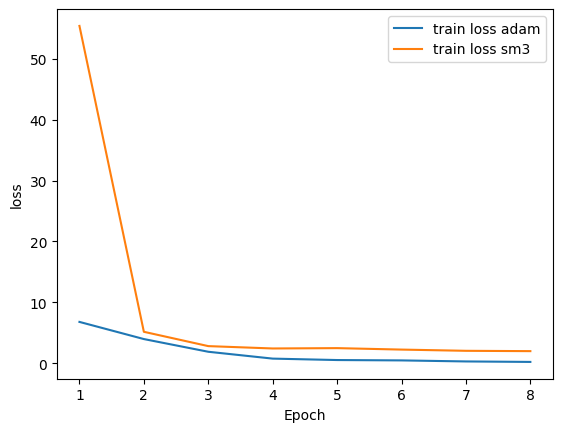

In [17]:
plt.plot(resnet.history.history["loss"], label = "train loss adam")
plt.plot(resnet_2.history.history["loss"], label = "train loss sm3")

plt.xlabel("Epoch")
plt.ylabel("loss")

plt.xticks(np.arange(8), labels = np.arange(1,9))

plt.legend()

plt.show()

In [18]:
resnet.history.history["loss"]

[6.78711462020874,
 3.9707555770874023,
 1.8853278160095215,
 0.7600002288818359,
 0.5258967280387878,
 0.46547552943229675,
 0.29600751399993896,
 0.21711045503616333]